### Import

In [43]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score


### Read Data

In [44]:
xml_file = "O-A0038-003.xml"

tree = ET.parse(xml_file)
root = tree.getroot()
ns = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}
lon0 = float(root.find('.//cwa:BottomLeftLongitude', ns).text)
lat0 = float(root.find('.//cwa:BottomLeftLatitude', ns).text)
content_text = root.find('.//cwa:Content', ns).text.strip()
values = [float(v) for v in content_text.replace('\n', ',').split(',') if v.strip()]
cols, rows = 67, 120
grid = np.array(values).reshape(rows, cols)

label_grid = np.where(grid == -999.0, 0, 1)
value_grid = np.where(grid == -999.0, np.nan, grid)

lon = np.linspace(lon0, lon0 + (cols - 1) * 0.03, cols)
lat = np.linspace(lat0, lat0 + (rows - 1) * 0.03, rows)
lon_mesh, lat_mesh = np.meshgrid(lon, lat)

### Drawing Data

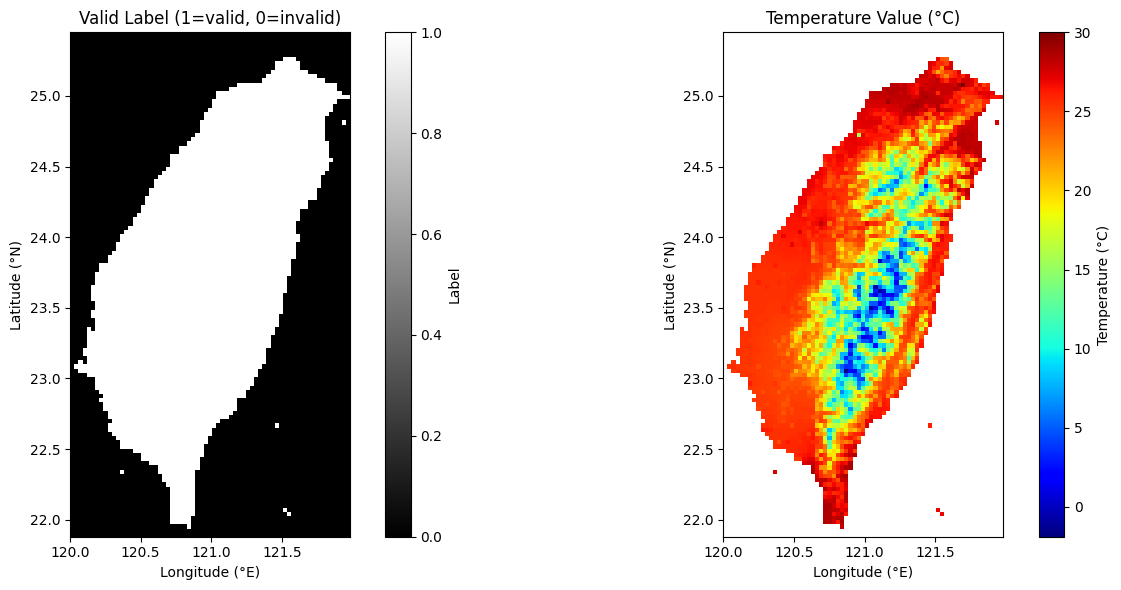

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im1 = axes[0].imshow(label_grid, extent=[lon.min(), lon.max(),
                                        lat.min(), lat.max()],
                     origin='lower', cmap='gray')
axes[0].set_title("Valid Label (1=valid, 0=invalid)")
axes[0].set_xlabel("Longitude (°E)")
axes[0].set_ylabel("Latitude (°N)")
fig.colorbar(im1, ax=axes[0], label="Label")

im2 = axes[1].imshow(value_grid, extent=[lon.min(), lon.max(),
                                        lat.min(), lat.max()],
                     origin='lower', cmap='jet')
axes[1].set_title("Temperature Value (°C)")
axes[1].set_xlabel("Longitude (°E)")
axes[1].set_ylabel("Latitude (°N)")
fig.colorbar(im2, ax=axes[1], label="Temperature (°C)")

plt.tight_layout()
plt.show()


### Make Dataset

In [46]:
lon_flat = lon_mesh.flatten()
lat_flat = lat_mesh.flatten()
lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()

def norm_coords(lon_vals, lat_vals):
    lon_n = (lon_vals - lon_min) / (lon_max - lon_min)
    lat_n = (lat_vals - lat_min) / (lat_max - lat_min)
    return lon_n, lat_n

lon_n, lat_n = norm_coords(lon_flat, lat_flat)
X = np.column_stack([lon_n, lat_n])
y = label_grid.flatten().astype(int)

rng = np.random.RandomState(42)
perm = np.random.choice(len(X), size=len(X), replace=False)
train_frac = 0.8
n_train = int(len(X) * train_frac)
train_idx = perm[:n_train]
test_idx = perm[n_train:]
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

### LDA Model

In [47]:
def fit_lda(X, y, reg=1e-6):
    n, d = X.shape
    phi = y.mean()
    X1 = X[y==1]
    X0 = X[y==0]
    mu1 = X1.mean(axis=0)
    mu0 = X0.mean(axis=0)
    S = np.zeros((d,d))
    for xi, yi in zip(X, y):
        mu = mu1 if yi==1 else mu0
        diff = (xi - mu).reshape(d,1)
        S += diff.dot(diff.T)
    sigma = S / n + reg*np.eye(d)
    inv_sigma = np.linalg.inv(sigma)
    return {'phi':phi,'mu0':mu0,'mu1':mu1,'sigma':sigma,'inv_sigma':inv_sigma}

def predict_proba_lda(model, X):
    inv_sigma = model['inv_sigma']
    mu0, mu1 = model['mu0'], model['mu1']
    phi = model['phi']
    w = inv_sigma.dot(mu1 - mu0)
    w0 = -0.5*mu1.dot(inv_sigma).dot(mu1) + 0.5*mu0.dot(inv_sigma).dot(mu0) + np.log(phi/(1-phi)+1e-12)
    logits = X.dot(w) + w0
    return 1 / (1 + np.exp(-logits))

def predict_lda(model, X):
    return (predict_proba_lda(model, X) >= 0.5).astype(int)

### LDA Training

In [48]:
model = fit_lda(X_train, y_train)

probs = predict_proba_lda(model, X_test)
preds = (probs >= 0.5).astype(int)

acc = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, probs)
cm = confusion_matrix(y_test, preds)

print(f'Testing Accuracy: {acc:.4f}')
print(f'Testing AUC:       {auc:.4f}')

Testing Accuracy: 0.5734
Testing AUC:       0.5651


### LDA Drawing

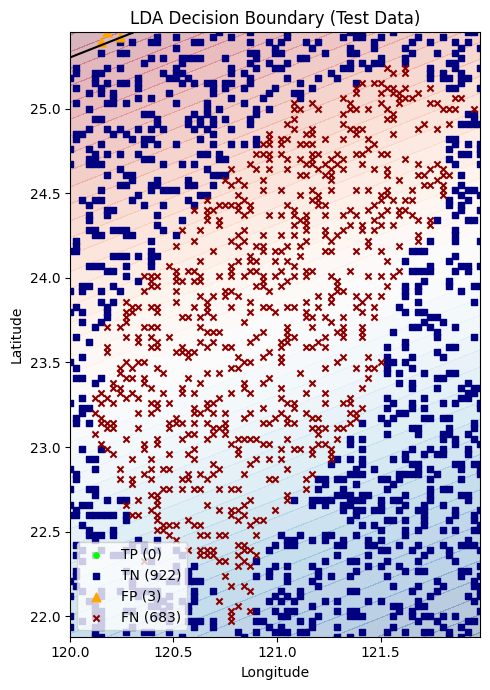

In [49]:
lon_n_mesh, lat_n_mesh = norm_coords(lon_mesh, lat_mesh)
grid_points = np.column_stack([lon_n_mesh.ravel(), lat_n_mesh.ravel()])
Z_lda = predict_proba_lda(model, grid_points).reshape(lon_mesh.shape)

lon_test = lon_flat[test_idx]
lat_test = lat_flat[test_idx]
probs_test = probs
preds_test = preds

tp_mask = (y_test == 1) & (preds_test == 1)
tn_mask = (y_test == 0) & (preds_test == 0)
fp_mask = (y_test == 0) & (preds_test == 1)
fn_mask = (y_test == 1) & (preds_test == 0)

plt.figure(figsize=(5, 7))
plt.contourf(lon_mesh, lat_mesh, Z_lda, levels=50, cmap='RdBu_r', alpha=0.3)
plt.contour(lon_mesh, lat_mesh, Z_lda, levels=[0.5], colors='black')

plt.scatter(lon_test[tp_mask], lat_test[tp_mask], c='lime', s=15, marker='o', label=f'TP ({tp_mask.sum()})')
plt.scatter(lon_test[tn_mask], lat_test[tn_mask], c='navy', s=15, marker='s', label=f'TN ({tn_mask.sum()})')
plt.scatter(lon_test[fp_mask], lat_test[fp_mask], c='orange', s=40, marker='^', label=f'FP ({fp_mask.sum()})')
plt.scatter(lon_test[fn_mask], lat_test[fn_mask], c='darkred', s=20, marker='x', label=f'FN ({fn_mask.sum()})')

plt.xticks(np.arange(120, 122,0.5))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'LDA Decision Boundary (Test Data)')
plt.legend(loc='lower left', frameon=True)
plt.tight_layout()
plt.savefig('LDA-test.png', dpi=300)
plt.show()


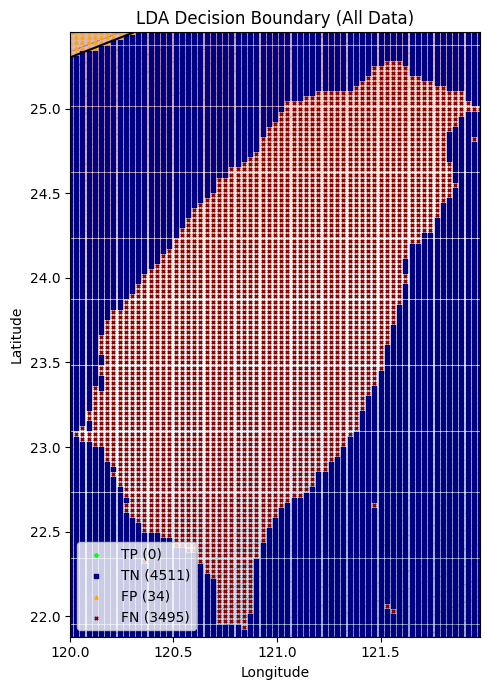

In [50]:
Z_all = predict_proba_lda(model, grid_points).reshape(lon_mesh.shape)

probs_all = predict_proba_lda(model, X)
preds_all = (probs_all >= 0.5).astype(int)

tp_mask = (y == 1) & (preds_all == 1)
tn_mask = (y == 0) & (preds_all == 0)
fp_mask = (y == 0) & (preds_all == 1)
fn_mask = (y == 1) & (preds_all == 0)

plt.figure(figsize=(5, 7))
plt.contourf(lon_mesh, lat_mesh, Z_all, levels=50, cmap='RdBu_r', alpha=0.3)
plt.contour(lon_mesh, lat_mesh, Z_all, levels=[0.5], colors='black')

plt.scatter(lon_flat[tp_mask], lat_flat[tp_mask], c='lime', s=5, marker='o', label=f'TP ({tp_mask.sum()})')
plt.scatter(lon_flat[tn_mask], lat_flat[tn_mask], c='navy', s=5, marker='s', label=f'TN ({tn_mask.sum()})')
plt.scatter(lon_flat[fp_mask], lat_flat[fp_mask], c='orange', s=5, marker='^', label=f'FP ({fp_mask.sum()})')
plt.scatter(lon_flat[fn_mask], lat_flat[fn_mask], c='darkred', s=5, marker='x', label=f'FN ({fn_mask.sum()})')

plt.xticks(np.arange(120, 122,0.5))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('LDA Decision Boundary (All Data)')
plt.legend(loc='lower left', frameon=True)
plt.tight_layout()
plt.savefig('LDA-all.png', dpi=300)
plt.show()


In [51]:
model_reg = fit_lda(X_train, y_train, reg=1e-2)


probs_all_reg = predict_proba_lda(model_reg, X)
preds_all_reg = (probs_all_reg >= 0.5).astype(int)

acc_all_reg = accuracy_score(y, preds_all_reg)

print('--- Regularized LDA Results ---')
print(f'Testing Accuracy: {acc:.4f}')
print(f'Testing AUC:       {auc:.4f}')
print(f'All Data Accuracy: {acc_all_reg:.4f}')


--- Regularized LDA Results ---
Testing Accuracy: 0.5734
Testing AUC:       0.5651
All Data Accuracy: 0.5653


### Define  Model

In [52]:
def fit_qda(X, y, reg=1e-6):
    phi = y.mean()
    X1, X0 = X[y == 1], X[y == 0]
    mu1, mu0 = X1.mean(axis=0), X0.mean(axis=0)
    sigma1 = np.cov(X1.T, bias=True) + reg * np.eye(X.shape[1])
    sigma0 = np.cov(X0.T, bias=True) + reg * np.eye(X.shape[1])
    return {'phi': phi, 'mu0': mu0, 'mu1': mu1, 'sigma0': sigma0, 'sigma1': sigma1}

def predict_proba_qda(model, X):
    mu0, mu1 = model['mu0'], model['mu1']
    s0, s1 = model['sigma0'], model['sigma1']
    inv0, inv1 = np.linalg.inv(s0), np.linalg.inv(s1)
    det0, det1 = np.linalg.det(s0), np.linalg.det(s1)
    
    def log_gauss(x, mu, inv, det):
        diff = x - mu
        term = -0.5 * np.sum(diff.dot(inv) * diff, axis=1)
        const = -0.5 * (x.shape[1] * np.log(2 * np.pi) + np.log(det + 1e-12))
        return term + const

    log0 = log_gauss(X, mu0, inv0, det0) + np.log(1 - model['phi'] + 1e-12)
    log1 = log_gauss(X, mu1, inv1, det1) + np.log(model['phi'] + 1e-12)
    maxlog = np.maximum(log0, log1)
    return np.exp(log1 - maxlog) / (np.exp(log0 - maxlog) + np.exp(log1 - maxlog))


### QDA training

In [53]:
qda_model = fit_qda(X_train, y_train)

qda_probs = predict_proba_qda(qda_model, X_test)
qda_preds = (qda_probs >= 0.5).astype(int)

qda_acc = accuracy_score(y_test, qda_preds)
qda_auc = roc_auc_score(y_test, qda_probs)

print(f'Testing Accuracy: {qda_acc:.4f}')
print(f'Testing AUC:       {qda_auc:.4f}')


Testing Accuracy: 0.8197
Testing AUC:       0.9306


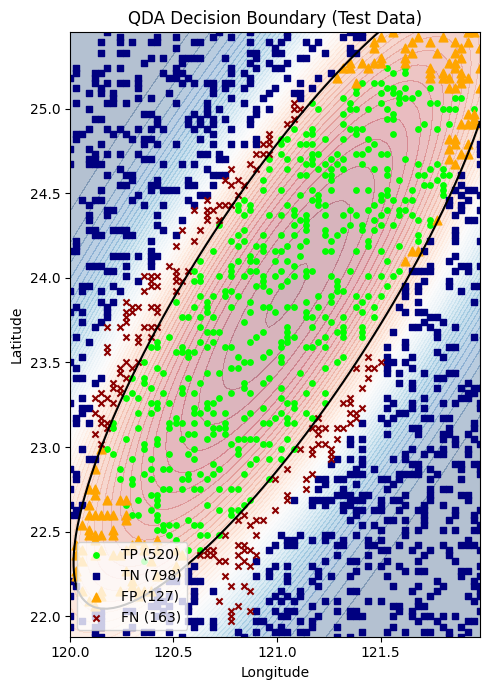

In [54]:
lon_n_mesh, lat_n_mesh = norm_coords(lon_mesh, lat_mesh)
grid_points = np.column_stack([lon_n_mesh.ravel(), lat_n_mesh.ravel()])
Z_qda = predict_proba_qda(qda_model, grid_points).reshape(lon_mesh.shape)

lon_test = lon_flat[test_idx]
lat_test = lat_flat[test_idx]

tp_mask = (y_test == 1) & (qda_preds == 1)
tn_mask = (y_test == 0) & (qda_preds == 0)
fp_mask = (y_test == 0) & (qda_preds == 1)
fn_mask = (y_test == 1) & (qda_preds == 0)

plt.figure(figsize=(5, 7))
plt.contourf(lon_mesh, lat_mesh, Z_qda, levels=50, cmap='RdBu_r', alpha=0.3)
plt.contour(lon_mesh, lat_mesh, Z_qda, levels=[0.5], colors='black')

plt.scatter(lon_test[tp_mask], lat_test[tp_mask], c='lime', s=15, marker='o', label=f'TP ({tp_mask.sum()})')
plt.scatter(lon_test[tn_mask], lat_test[tn_mask], c='navy', s=15, marker='s', label=f'TN ({tn_mask.sum()})')
plt.scatter(lon_test[fp_mask], lat_test[fp_mask], c='orange', s=40, marker='^', label=f'FP ({fp_mask.sum()})')
plt.scatter(lon_test[fn_mask], lat_test[fn_mask], c='darkred', s=20, marker='x', label=f'FN ({fn_mask.sum()})')

plt.xticks(np.arange(120, 122,0.5))
plt.xlabel('Longitude')

plt.ylabel('Latitude')
plt.title(f'QDA Decision Boundary (Test Data)')
plt.legend(loc='lower left', frameon=True)
plt.tight_layout()
plt.savefig('QDA-test.png', dpi=300)
plt.show()


QDA Accuracy: 0.8197


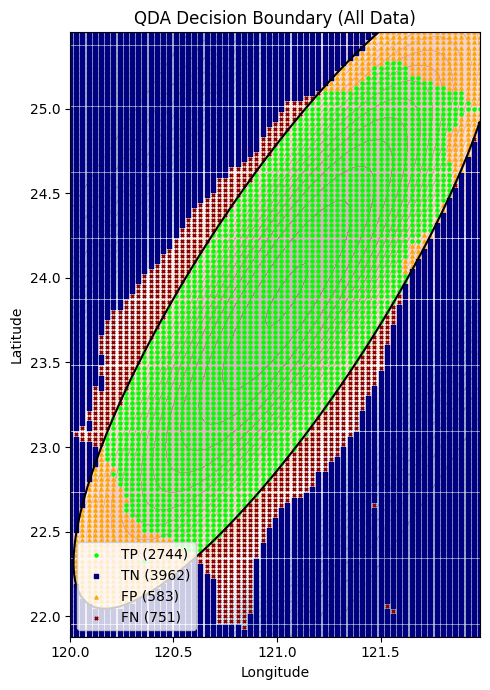

In [55]:
qda_model = fit_qda(X_train, y_train)
qda_probs = predict_proba_qda(qda_model, X_test)
qda_preds = (qda_probs >= 0.5).astype(int)

qda_acc = accuracy_score(y_test, qda_preds)
qda_auc = roc_auc_score(y_test, qda_probs)
print(f'QDA Accuracy: {qda_acc:.4f}')

lon_n_mesh, lat_n_mesh = norm_coords(lon_mesh, lat_mesh)
grid_points = np.column_stack([lon_n_mesh.ravel(), lat_n_mesh.ravel()])
Z_qda = predict_proba_qda(qda_model, grid_points).reshape(lon_mesh.shape)

probs_all = predict_proba_qda(qda_model, X)
preds_all = (probs_all >= 0.5).astype(int)

tp_mask = (y == 1) & (preds_all == 1)
tn_mask = (y == 0) & (preds_all == 0)
fp_mask = (y == 0) & (preds_all == 1)
fn_mask = (y == 1) & (preds_all == 0)

plt.figure(figsize=(5, 7))
plt.contourf(lon_mesh, lat_mesh, Z_qda, levels=50, cmap='RdBu_r', alpha=0.3)
plt.contour(lon_mesh, lat_mesh, Z_qda, levels=[0.5], colors='black')

plt.scatter(lon_flat[tp_mask], lat_flat[tp_mask], c='lime', s=5, marker='o', label=f'TP ({tp_mask.sum()})')
plt.scatter(lon_flat[tn_mask], lat_flat[tn_mask], c='navy', s=5, marker='s', label=f'TN ({tn_mask.sum()})')
plt.scatter(lon_flat[fp_mask], lat_flat[fp_mask], c='orange', s=5, marker='^', label=f'FP ({fp_mask.sum()})')
plt.scatter(lon_flat[fn_mask], lat_flat[fn_mask], c='darkred', s=5, marker='x', label=f'FN ({fn_mask.sum()})')

plt.xticks(np.arange(120, 122,0.5))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('QDA Decision Boundary (All Data)')
plt.legend(loc='lower left', frameon=True)
plt.tight_layout()
plt.savefig('QDA-all.png', dpi=300)
plt.show()

In [56]:
probs_all = predict_proba_qda(qda_model, X)
preds_all = (probs_all >= 0.5).astype(int)
acc_all = accuracy_score(y, preds_all)

qda_model_reg = fit_qda(X_train, y_train, reg=1e-2)

acc_all_reg = accuracy_score(y, (predict_proba_qda(qda_model_reg, X) >= 0.5).astype(int))

print('--- Regularized QDA Results ---')
print(f'Testing Accuracy: {qda_acc:.4f}')
print(f'Testing AUC:       {qda_auc:.4f}')
print(f'All Data Accuracy: {acc_all_reg:.4f}')


--- Regularized QDA Results ---
Testing Accuracy: 0.8197
Testing AUC:       0.9306
All Data Accuracy: 0.8531
